# QSAR/QSPR Models Fine-Tuning 2: Regression 

This notebook is an example of a classification task on **Lipophilicity** dataset. Lipophilicity, refers to the ability of a chemical compound to dissolve in fats, oils, lipids, and non-polar solvents such as hexane or toluene.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from fastai import *
from fastai.text import *
from utils import *

torch.cuda.set_device(1) #change to 0 if you only has one GPU 

RDKit WARNING: [10:01:20] Enabling RDKit 2019.09.3 jupyter extensions


In [12]:
data_path = Path('../results')
name = 'Lipophilicity'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

## Load Data

Dataset: (4200, 2)


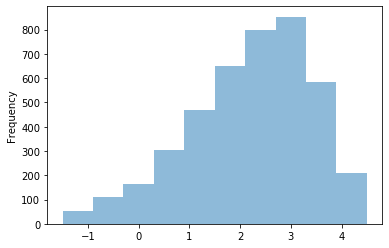

In [3]:
lipo_data = pd.read_csv('../data/QSAR/lipo.csv')
print('Dataset:', lipo_data.shape)
lipo_data.lipo.plot.hist(alpha=0.5)

We benchmarked our MolPMoFiT method to other published models from [Yang et al](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00237) on
three well-studied datasets: **lipophilicity**, **HIV** and **BBBP**. All the models were evaluated on the
same ten 80:10:10 [splits](https://github.com/swansonk14/chemprop/blob/master/splits.tar.gz) from Yang et al to ensure a fair and reproducible benchmark.

In [4]:
# Change the split type and id to nagivate different splits.
dataset = 'lipo'
split_type = 'scaffold'
split_id = 11

split_file = f'{dataset}/{split_type}/split_indices{split_id}.pckl'


with open(f'../data/QSAR/splits/{split_file}', 'rb') as f:
    split = pickle.load(f)
    
print('Train Set:', len(split[0]))
print('Valid Set:', len(split[1]))
print('Test Set:', len(split[2]))


Train Set: 3360
Valid Set: 420
Test Set: 420


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0dbdb684e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0dbdb684e0>)

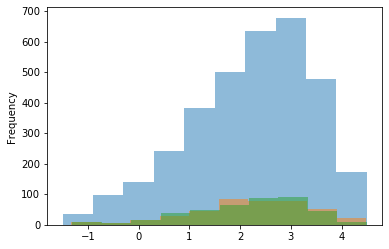

In [5]:
train = lipo_data.iloc[split[0]]
valid = lipo_data.iloc[split[1]]
test = lipo_data.iloc[split[2]]
train.lipo.plot.hist(alpha=0.5), valid.lipo.plot.hist(alpha=0.5), test.lipo.plot.hist(alpha=0.5)

## Data Augmentation

In addition to SMILES
augmentation, for regression QSAR/QSPR models, a Gaussian noise (mean set at 0 and standard
deviation σnoise) is added to the labels of augmented SMILES.

In [7]:
def lipo_smiles_augmentation(df, N_rounds, noise = 0.1):
    '''
    noise: add gaussion noise to the label
    '''
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['lipo'].append(df.iloc[i]['lipo'] + np.random.normal(0,noise))
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [9]:
train_aug = lipo_smiles_augmentation(train, 25, noise=0.1)
valid_aug = lipo_smiles_augmentation(valid, 5, noise=0)

## Adpot the Encoder of MSPM According to the Target Dataset.

In [10]:
bs = 128
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=6, pre_rules=[], post_rules=[])

In [13]:
qsar_vocab = TextLMDataBunch.from_df(path, train_aug, valid_aug, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols=0,label_cols=1, max_vocab=60000, include_bos=False)
print(f'Vocab Size: {len(qsar_vocab.vocab.itos)}')

Vocab Size: 48


In [14]:
pretrained_model_path = Path('../results/MSPM/models')
pretrained_fnames = ['MSPM_wt', 'MSPM_vocab']
fnames = [pretrained_model_path/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]

In [15]:
lm_learner = language_model_learner(qsar_vocab, AWD_LSTM, drop_mult=1.0)
lm_learner = lm_learner.load_pretrained(*fnames)
lm_learner.freeze()
lm_learner.save_encoder(f'lm_encoder')

## Databunch for QSAR Modeling

You need to change the `text_cols` and `label_col` based on your dataset.

In [16]:
data_clas = TextClasDataBunch.from_df(path, train_aug, valid_aug, bs=bs, tokenizer=tok, 
                                          chunksize=50000, text_cols='smiles',label_cols='lipo', 
                                          vocab=qsar_vocab.vocab, max_vocab=60000, include_bos=False)

## Fine-tuning

For regression models, we change the metrics to  `R2` and `root_mean_squared_error`.

In [18]:
reg_learner = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.2, metrics = [r2_score, root_mean_squared_error])
reg_learner.load_encoder(f'lm_encoder')
reg_learner.freeze()

In [19]:
reg_learner.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.806567,1.376498,-0.087567,1.165167,01:04
1,0.651465,0.908048,0.307396,0.938451,01:04
2,0.541040,0.738835,0.423201,0.857494,01:07
3,0.469785,0.792124,0.390247,0.877914,01:00


In [20]:
reg_learner.freeze_to(-2)
reg_learner.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.359726,0.601028,0.531652,0.772481,01:16
1,0.273021,0.608182,0.531695,0.770718,01:16
2,0.203613,0.545042,0.579073,0.732291,01:16
3,0.196842,0.584743,0.548645,0.754361,01:17


In [21]:
reg_learner.freeze_to(-3)
reg_learner.fit_one_cycle(4, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.174926,0.537759,0.584421,0.726427,02:18
1,0.169357,0.536761,0.585134,0.727137,02:13
2,0.182205,0.547277,0.579974,0.730224,02:13
3,0.175797,0.565851,0.567618,0.739608,02:17


In [22]:
reg_learner.unfreeze()
reg_learner.fit_one_cycle(6, slice(5e-5/(2.6**4),5e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.150726,0.541696,0.584454,0.726713,03:07
1,0.179887,0.543199,0.582986,0.727786,03:00
2,0.173607,0.542934,0.582697,0.728263,02:51
3,0.153854,0.545752,0.580628,0.729700,02:50
4,0.168290,0.543155,0.581209,0.728961,03:11
5,0.175848,0.553263,0.575478,0.732838,02:58


In [23]:
reg_learner.save(f'{split_type}_{split_id}_reg')

## Test on the Test Set

1. Test only on Canoicial SMILES (Canonical)
2. Test on averaging prediction of canoicial and randomized SMILES (Average).

In [25]:
def test_smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
            dist_aug['lipo'].append(df.iloc[i]['lipo'])
    df_aug = pd.DataFrame.from_dict(dist_aug)
    
    return pd.DataFrame.from_dict(dist_aug)

In [26]:
preds = []

# Randomized SMILES Predictions
for i in range(4):
    np.random.seed(12*i)
    test_aug = test_smiles_augmentation(test,1)
    
    #model
    test_db = TextClasDataBunch.from_df(path, train, test_aug, tokenizer=tok, vocab=qsar_vocab.vocab,
                                            text_cols='smiles', label_cols='lipo', bs=bs, include_bos=False)
    learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.2,metrics = [r2_score, root_mean_squared_error])
    learner.load(f'{split_type}_{split_id}_reg'); 
    
    #get predictions
    pred,lbl = learner.get_preds(ordered=True)
    
    preds.append(pred)

# Canonical SMILES Predictions
test_db = TextClasDataBunch.from_df(path, train, test, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols='smiles',label_cols='lipo', vocab=qsar_vocab.vocab, max_vocab=60000,
                                              include_bos=False)

learner = text_classifier_learner(test_db, AWD_LSTM, pretrained=False, drop_mult=0.2,metrics = [r2_score, root_mean_squared_error])
learner.load(f'{split_type}_{split_id}_reg');


#get predictions
pred_canonical,lbl = learner.get_preds(ordered=True)
    
preds.append(pred_canonical)




In [27]:
print('Test Set (Canonical)')
print('RMSE:', root_mean_squared_error(pred_canonical,lbl))
print('R2:', r2_score(pred_canonical,lbl))
print('MAE:', mean_absolute_error(pred_canonical,lbl))


Test Set (Canonical)
RMSE: tensor(0.7108)
R2: tensor(0.6159)
MAE: tensor(0.5230)


In [28]:
avg_preds = sum(preds)/len(preds)
print('\n')
print('Test Set (Average)')
print('RMSE:', root_mean_squared_error(avg_preds,lbl))
print('R2:', r2_score(avg_preds,lbl))
print('MAE:', mean_absolute_error(avg_preds,lbl))



Test Set (Average)
RMSE: tensor(0.6613)
R2: tensor(0.6675)
MAE: tensor(0.4774)
